Read in the contents of both csv files and display the first few lines of the training set.

In [52]:
import pandas as pd
training = pd.read_csv('training.csv')
testing = pd.read_csv('testing.csv')
training.head()

,class,b1,b2,b3,b4,b5,b6,b7,b8,b9,...,pred_minus_obs_H_b9,pred_minus_obs_S_b1,pred_minus_obs_S_b2,pred_minus_obs_S_b3,pred_minus_obs_S_b4,pred_minus_obs_S_b5,pred_minus_obs_S_b6,pred_minus_obs_S_b7,pred_minus_obs_S_b8,pred_minus_obs_S_b9
0,d,67,51,68,115,69,111,136,31,67,...,-9.17,-18.27,-1.80,-6.32,-20.88,-1.63,-6.13,-22.56,-5.53,-8.11
1,s,67,28,51,99,50,97,82,26,59,...,-2.25,-20.13,-2.11,-6.35,-21.94,-1.22,-6.13,-22.20,-3.41,-6.57
2,s,63,26,50,95,49,91,81,26,57,...,-0.44,-17.64,-1.81,-4.70,-19.39,-0.65,-5.01,-20.89,-3.96,-6.85
3,d,63,42,63,97,66,108,111,28,59,...,-2.34,-20.20,-1.89,-5.47,-21.65,-0.99,-5.71,-22.19,-3.41,-6.52
4,s,46,27,50,83,51,90,76,26,56,...,1.25,-18.62,-2.17,-7.11,-21.12,-1.56,-6.35,-22.19,-4.45,-7.32


Display the histagrams for visualising the training data for each attribute.

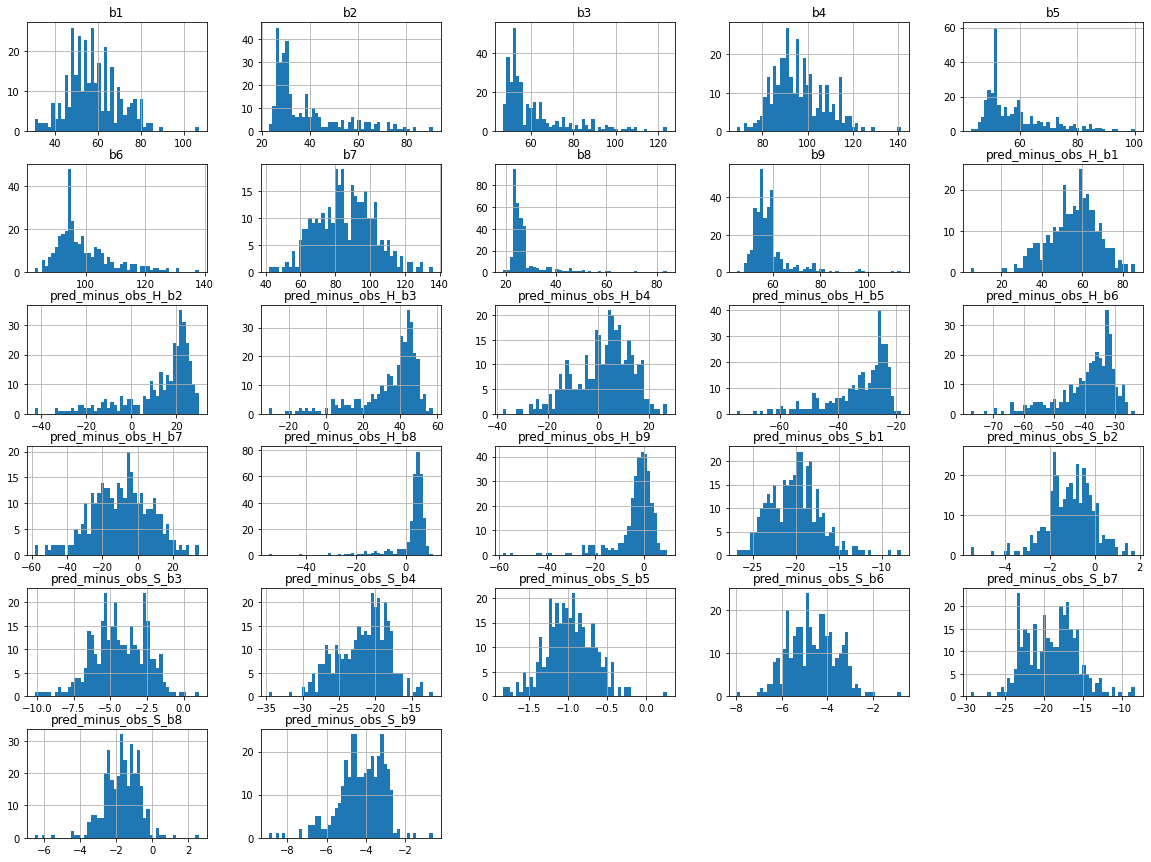

In [53]:
from matplotlib import pyplot as plt
training.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots", format="png", dpi=300)
plt.show()

Filter out all the columns whose name starts with `pred_minus_obs` using a list comprehension.

In [54]:
training.drop(columns=[column for column in training if column.startswith('pred_minus_obs')], inplace=True)
training.info()
testing.drop(columns=[column for column in testing if column.startswith('pred_minus_obs')], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   325 non-null    object
 1   b1      325 non-null    int64 
 2   b2      325 non-null    int64 
 3   b3      325 non-null    int64 
 4   b4      325 non-null    int64 
 5   b5      325 non-null    int64 
 6   b6      325 non-null    int64 
 7   b7      325 non-null    int64 
 8   b8      325 non-null    int64 
 9   b9      325 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 25.5+ KB


Display the scatter matrix for visualising the correlation between the attributes. It looks like b1 to b9 all have a linear correlation. The scale are all from 0 to 150.

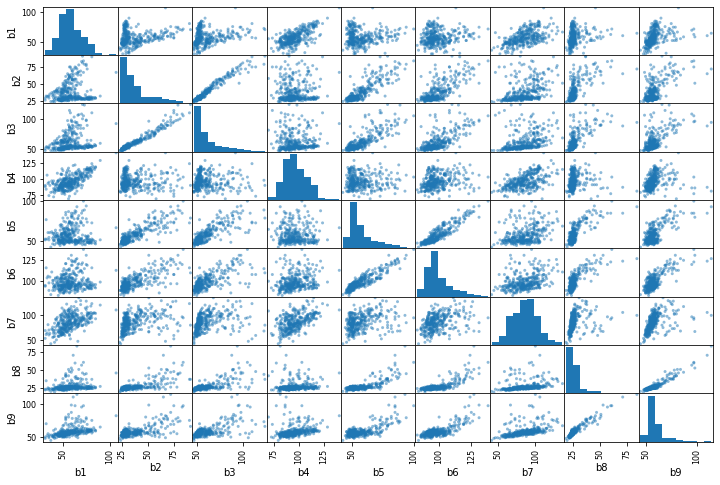

In [55]:
from pandas.plotting import scatter_matrix
scatter_matrix(training, figsize=(12, 8))
plt.savefig("scatter_matrix_plot", format="png", dpi=300)
plt.show()

Count the number of instances for each class label. It looks like there is an imbalanced amount of data for class `h`.

In [56]:
training[training.columns[0]].value_counts()

s    136
d    105
o     46
h     38
Name: class, dtype: int64

Prepare the data for machine learning algorithms.

In [57]:
X = training.drop('class', axis=1) # drop labels for training set
Y = training['class']
ground_truth = testing['class']

Apply feature scaling to both training data and test data.

In [58]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
testing = scaler.transform(testing.drop('class', axis=1))

Define a grid search function that given an estimator and 2 hyperparameters, uses 3-fold cross validation to find the optimal values for these 2 hyperparameters that maximise the classification accuracy.

In [59]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
def grid_search(estimator: BaseEstimator, param_grid: dict, X, Y) -> GridSearchCV:
	grid_search = GridSearchCV(estimator, param_grid, cv=3)
	grid_search.fit(X, Y)
	return grid_search

For `Support Vector Machine Classifier`'s hyperparameters `C` and `kernel` the value `2` and `rbf` gave the highest classification accuracy which will be used to train the model along with the `decision_function_shape` hyperparameter set to `ovo` meaning using the `one-versus-one` strategy. The rest of the hyperparameters are left as their default value.

In [60]:
from sklearn.svm import SVC
param_grid: dict = {
	'C': [0.2, 1, 2, 4],
	'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
model = grid_search(SVC(decision_function_shape='ovo'), param_grid, X, Y)
model.best_params_

{'C': 2, 'kernel': 'rbf'}

Define a performance function that given a model and the ground_truth, displays the confusion matrix with the 4 classes as labels and returns the accuracy measured using the test set.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
def performance(model, ground_truth) -> float:
	y_pred = model.predict(testing)
	labels = ['s', 'h', 'd', 'o']
	display = ConfusionMatrixDisplay(confusion_matrix(ground_truth, y_pred, labels=labels), display_labels=labels)
	display.plot()
	return accuracy_score(ground_truth, y_pred)

The performance of the `Support Vector Machine Classifier` has an accuracy of `91.41%`. From the confusion matrix 9 instances of `h` were identified as `s` which is the major factor contributing to the lower accuracy.

0.9141414141414141

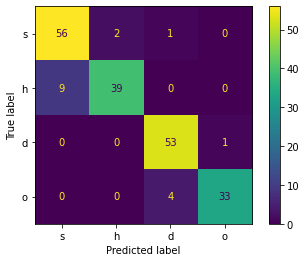

In [61]:
performance(model, ground_truth)

For `Stochastic Gradient Descent Classifier`'s hyperparameters `penalty` and `alpha` the value `0.0001` and `l1` gave the highest classification accuracy which will be used to train the model along with the `random_state` hyperparameter set to a fixed number which gives the same result every time the model is trained. The rest of the hyperparameters are left as their default value.

In [62]:
from sklearn.linear_model import SGDClassifier
param_grid = {
	'penalty': ['l1', 'l2', 'elasticnet'],
	'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
}
model = grid_search(SGDClassifier(random_state=42), param_grid, X, Y)
model.best_params_

{'alpha': 0.0001, 'penalty': 'l1'}

The performance of the `Stochastic Gradient Descent Classifier` has an accuracy of `93.43%`. The number of false negatives and false positives are slightly fewer than the `SVM` model which results in a higher accuracy.

0.9343434343434344

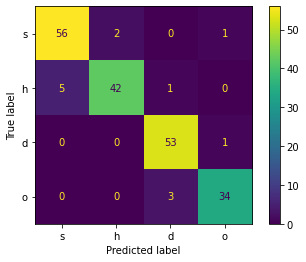

In [63]:
performance(model, ground_truth)

From the results the `Stochastic Gradient Descent Classifier` performs better than `SVM Classifier`. Though this might not always be the case as `SVM` picks a random instance in the training step each time which introduces uncertainty in its accuracy. Additionally only 2 hyperparameters from each model were fine tuned, it might be a different result if more were used. Both models tend to mix up most commonly `h` and `s`, and then `d` and `o`.